## 1. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statistics import mode, multimode
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr, f_oneway
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
from datetime import date
import time
import re

import requests
from bs4 import BeautifulSoup

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler,\
                                  MinMaxScaler, KBinsDiscretizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

%matplotlib inline
warnings.filterwarnings('ignore')

## 2. Определение функций

In [2]:
# Проверка запросов с возвратом кода ответа
def get_html(url, params=None):
    response = requests.get(url, params=params)
    response.encoding = 'utf-8'
    return response

In [3]:
# Визуализация данных
def histogram(df):
    sns.set()
    f, axes = plt.subplots(figsize=(15, 5))
    sns.distplot(df, kde = False, rug=False)
    plt.xticks(rotation=90)
    
def boxplot(x_data, y_data, data):
    sns.set(style="ticks", palette="pastel")
    f, axes = plt.subplots()
    sns.boxplot(x=x_data, y=y_data, palette=['m', 'g'], data = data)
    sns.despine(offset=10, trim=True)
    
def countplot(x_data, df):
    f, ax = plt.subplots(figsize=(16, 9))
    ax = sns.countplot(x=x_data, data=df)
    plt.xticks(rotation=90)
    
def bar(column):
    """
    Plots pie chart and bar chart
    for given categorical feature
    """
    fig, axes = plt.subplots(figsize=(12, 6))
    
    sns.barplot(x=train[column].astype(str).value_counts().index[:5],
                y=train[column].value_counts(normalize=True).values[:5],
                palette='magma')
    plt.title(f'Top train categories for "{column}"',
              size=15)
    plt.ylabel('Proportion')
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(wspace=0.2);

def dist_box(data, column):
    """
    Plots distribution
    and boxplot for given
    numeric feature
    """
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))
    sns.kdeplot(data[column], ax=axes[0][0],
                color='r', shade=True)
    axes[0][0].set_title(f'Distribution for "{column}"',
                      size=15)
    sns.boxplot(data[column], ax=axes[0][1],
                color='r', meanline=True)
    axes[0][1].set_title(f'Box plot for "{column}"',
                      size=15)
    
    sns.kdeplot(np.log(data[column] + 1), ax=axes[1][0],
                color='violet', shade=True)
    axes[1][0].set_title(f'Log-distribution for "{column}"',
                      size=15)
    
    sns.boxplot(np.log(data[column] + 1), ax=axes[1][1],
                color='violet', meanline=True)
    axes[1][1].set_title(f'Box plot for logarithmic "{column}"',
                      size=15)
    
    robust_scaler = RobustScaler(quantile_range = (0.25, 0.75)).\
    fit_transform(data[column].values.reshape(-1, 1))
#     scaler = StandardScaler().fit_transform(data[column].values.reshape(-1, 1))
    
    sns.kdeplot(np.log(robust_scaler.reshape(len(robust_scaler), ) + 1), 
                ax=axes[2][0], color='green', shade=True)
    
    axes[2][0].set_title(f'Robust log-distribution for"{column}"', size=15)
    
    sns.boxplot(np.log(robust_scaler + 1), ax=axes[2][1], color='green', meanline=True)
    axes[2][1].set_title(f'Box plot for robust logarithmic "{column}"',
                      size=15)
    
    minmax_scaler = MinMaxScaler().fit_transform(data[column].values.reshape(-1, 1))
    
    sns.kdeplot(minmax_scaler.reshape(len(minmax_scaler), ), 
                ax=axes[3][0], color='orange', shade=True)
    
    axes[3][0].set_title(f'Minmax normalized for"{column}"', size=15)
    
    sns.boxplot(minmax_scaler, ax=axes[3][1], color='orange', meanline=True)
    axes[3][1].set_title(f'Box plot for minmax normalized "{column}"',
                      size=15)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.3);
    
def outliers(column):
    """
    This function detects
    outliers relying on
    IQR and displays IQR bounds
    and the number of outliers
    """
    Q1 = np.quantile(column, 0.25)
    Q3 = np.quantile(column, 0.75) 
    IQR = Q3 - Q1
    left_bound = Q1 - 1.5*IQR
    right_bound = Q3 + 1.5*IQR
    bounds = pd.Series({'left bound': left_bound,
                        'right bound': right_bound})
    number_of_outliers = column[(column > right_bound) | (column < left_bound)]
    return bounds, number_of_outliers.shape[0]

def show_plots(x_data, y_data, data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 9)) # 3 графика на один признак в ряд
    fig.suptitle('QQ-plot, histogram and boxplot for {0}'.format(value))
    
    fig = sm.qqplot(y_data.dropna(), fit = True, line ='45', ax=ax1) # сравнение с нормальным распределением
    sns.distplot(y_data.dropna(), kde=False, bins=50, ax=ax2) # гистограмма
    sns.boxplot(x=x_data.dropna(), y=y_data.dropna(), data=data, palette='rainbow', ax=ax3) # выбросы
    
    plt.show

In [4]:
# MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

## 3. Загрузка данных

По условиям задания имеем тестовый датасет и вариант загрузки результатов на kaggle. Тренировочный датасет предстоит собрать самим.

In [5]:
data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
data['sell_id'].to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/sell_id.xlsx')

In [7]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [8]:
print('Размерность тестового датасета: ', data.shape)

Размерность тестового датасета:  (34686, 32)


In [9]:
data.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Описание переменных:

1. bodyType - тип кузова. 24 варианта: седан

2. brand - автомобильный бренд

3. car_url - ссылка на объявление

4. color - цвет автомобиля

5. complectation_dict - словарь с содержимым комплектации

6. description - описание продавца

7. engineDisplacement - объем двигателя (нужно будет подчистить от LTR)

8. enginePower - мощность двигателя (нужно будет подчистить от N12)

9. equipment_dict - словарь с оснащением, ключ - тип оснащения, а значение только true

10. fuelType - тип используемого топлива

11. image - ссылка на фото

12. mileage - пробег

13. modelDate - год появления модели

14. model_info - словарь с названием модели на ангийском и русском, а также семантическая информация (можно попробовать выделить название модели на русском, если потребуется)

15. model_name - название модели на англ.

16. name - сокращенное наименование комплектации автомобиля (тип двигателя, его мощность, тип коробки передач, полный привод)

17. numberOfDoors - кол-во дверей

18. parsing_unixtime - время в момент парсинга в формате unix 

19. priceCurrency - у всех значений RUB.

20. productionDate - год выпуска

21. sell_id - идентификатор объявления

22. super_gen - словарь с информацией о комплектации: id, масса, тип двигателя, марка шин, тип трансмиссии, мощность в лс, мощность в квт, краткое описание комплектации, время разгона до 100, величина дорожного просвета, экологическая характеристика.

23. vehicleConfiguration - три значения на англ.: тип кузова, тип трансмиссии, объем двигателя

24. vehicleTransmission - тип трансмиссии на русском

25. vendor - страна происхождения марки: европа, япония

26. Владельцы - число владельцев: 1, 2, 3 и более. Нужно подчистить от окончания по роду -лец -лица

27. Владение - продолжительность владения число лет и месяцев

28. ПТС - оригинал или дубликат

29. Привод - перезний, задний, полный

30. Руль - правый или левый

31. Состояние - у всех значение - Не требует ремонта

32. Таможня - у всех значение - растаможен


## 4. Предварительный анализ данных тестовой выборки

In [11]:
features = data.columns
for col in features:
   print('Уникальные значения в поле {0} : {1}'.format(col, data[col].unique()))

Уникальные значения в поле bodyType : ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон']
Уникальные значения в поле brand : ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
Уникальные значения в поле car_url : ['https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'
 'https://auto.ru/cars/used/sale/skoda/octavia/1100549428-595cadf2/'
 'https://auto.ru/cars/used/sale/skoda/superb/1100658222-7ac3def5/' ...
 'https://auto.ru/cars/used/sale/bmw/5er/1101364889-0c6be825/'
 'https://auto.ru/cars/used/sale/bmw/x1/1101362518-34628283/'
 'https://auto.ru/cars/used/sale/bmw/x5/1101256068-ed03accb/']
Уникальные значения в

Уникальные значения в поле description : ['Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию м

Уникальные значения в поле super_gen : ['{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'
 '{"id":"20913311","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":110,"power_kvt":81,"human_name":"1.6 MT (110 л.с.)","acceleration":10.8,"clearance_min":156,"fuel_rate":6.4}'
 '{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'
 ...
 '{"id":"21221044","name":"320","nameplate":"320i","displacement":1991,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"MECHANICAL","power":150,"power_kvt":110,"human_name":"320i 2.0 MT (

In [12]:
data.describe(include = 'object')

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
count,34686,34686,34686,34686,6418,34686,34686,34686,24690,34686,...,34686,34686,34686,34686,11995,34685,34686,34686,34686,34686
unique,24,12,34686,16,2364,31732,55,315,23705,5,...,634,4,2,3,275,2,3,2,1,1
top,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1092383...,чёрный,"{""id"":""4562904"",""name"":""Elegance"",""available_o...",Выгода до 82 000 руб. при обмене на Ваш автомо...,2.0 LTR,249 N12,"{""leather"":true}",бензин,...,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
freq,13147,4473,1,11010,51,264,7391,1708,108,28601,...,2389,19596,20682,15957,209,30098,15565,33287,34686,34686


#### car_url
Пока не вижу смысла включать эти данные в итоговый датасет.

#### complectation_dict
Можно подтянуть данные по опциям автомобиля, но это займет время и будет много пропусков, что негативно скажется на модели, по моему мнению. Пока думаю убрать из итогового ДС.

#### engineDisplacement
Нужно привести в соответствие с данными с сайта, поэтому оставляем только две цифры с разелительной точкой, остальное подчищаем.

In [13]:
col = 'engineDisplacement'
data[col] = data[col].str.extract(r'(\d.\d)').astype(float)

In [14]:
# Наличие пропусков в том, что это электромобили без ДВС
col = 'engineDisplacement'
data.query('engineDisplacement=="NaN"')

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
5241,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/e_tron/110...,белый,NaN,Audi e-tron Prestige quattro от Moscow Tesla C...,NaN,408 N12,"{""asr"":true,""esp"":true,""usb"":true,""e-adjustmen...",электро,...,ALLROAD_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7992,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11010431...,синий,NaN,"Атомобиль из Германии,без пробега по РФ.\nНа г...",NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8252,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012780...,серый,NaN,"Пробег 54000 км, запас хода на зарядке 130 км+...",NaN,170 N12,"{""park-assist-f"":true,""park-assist-r"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8350,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11002716...,белый,"{""id"":""21624597"",""name"":""i3 120 Ah"",""available...","Автомобиль в наличии Москве , с ПТС , производ...",NaN,170 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8684,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11011745...,чёрный,NaN,BMW I 3 REX\nфевраль 2017 года выпуска.\nПриоб...,NaN,170 N12,"{""cruise-control"":true,""glonass"":true,""navigat...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8722,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11000973...,голубой,NaN,\nПрибыло из Америки в августе 2020 года. Полн...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8917,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11008715...,бежевый,NaN,-Состояние нового автомобиля .\n-Carfax вся ис...,NaN,170 N12,"{""glonass"":true,""roof-rails"":true}",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10817,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012664...,серый,NaN,Продаю BMW I3 +REX .\n\nПолноценный электромоб...,NaN,170 N12,NaN,электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10936,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10996733...,чёрный,NaN,Автомобиль BMW i3 (полностью электрический )за...,NaN,170 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
11043,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/10993761...,серый,NaN,Состояние нового автомобиля . \nФото ИМЕННО ЭТ...,NaN,170 N12,"{""glonass"":true,""airbag-driver"":true,""aux"":tru...",электро,...,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен


#### enginePower
Убираем лишние символы.

In [15]:
col = 'enginePower'
data[col] = data[col].str.extract(r'(\d{2,3})').astype(int)

#### equipment_dict
Аналогично 'complectation_dict', но здесь данные чище. Можно попробовать сделать dummie-переменные. Но: много объявлений, где отсутствует частично или полностью. Не буду включать в итоговый датасет.

#### image
Объект представляет собой ссылку на фото автомобиля. Не будем включать в итоговый датасет. Компьютерное зрение на данном этапе не планируется к применению. Не будем включать в итоговый датасет.

#### modelDate
Данной информации на auto.ru нет. Нужно будет подтягивать со сторонних ресурсов. Достаточно важная информация, т.к. рестайлинг может быть в середине года и автомобили одного года могут быть в разных ценвых категориях. Пока эту мысль не реализовал.

#### model_info
Здесь можно взять название модели на русском языке. Использовать эту информацию в поиске. Нет мыслей на этот счет. Не будем включать в итоговый датасет.

#### name
Информация дублируется с другими столбцами, например объем двигателя, тип топлива, тип трансмиссии, мощность двигателя. Возьмем отсюда объем двигателя.

In [16]:
col = 'name'
data[col] = data[col].str.extract(r'(\d\.\d)')

In [17]:
data[col].unique()

array(['1.2', '1.6', '1.8', '2.0', '1.4', '1.3', '1.0', '3.6', '1.5',
       '1.9', '2.8', '1.1', '2.5', '4.2', '3.0', '4.0', '5.9', '2.7',
       '3.1', '2.4', '5.2', '3.2', '4.1', '6.3', '2.3', '6.0', '2.2',
       '3.7', '2.9', '5.0', '3.3', '2.1', '2.6', nan, '3.5', '1.7', '0.7',
       '4.4', '4.8', '5.4', '6.6', '4.9', '3.8', '3.4', '3.9', '4.6',
       '5.6', '4.5', '5.5', '6.2', '4.7', '4.3', '5.8', '5.3', '5.7'],
      dtype=object)

#### numberOfDoors
Информация частично дублируется с другим параметром. На сайте auto.ru такой информации нет. Не будем включать этот столбец в итоговый датасет.

#### priceCurrency
Все значения одинаковы. Можно не включать в итоговый датасет.

#### sell_id
Нужна только для загрузки на kaggle. При составлении модели нужно убрать ее.

In [18]:
data_id = data.sell_id

#### super_gen
Частично информация дублируется с другими параметрами датасета, частично не представленна на auto.ru. Не будем включать в итоговый датасет.

#### vehicleConfiguration
Частично информация дублируется с другими параметрами датасета. Не будем включать в итоговый датасет.

#### Владельцы
Удалим лишние символы.

In [19]:
col = 'Владельцы'
data[col] = data[col].str.extract(r'(\d)').astype(float)

#### Владение
Тип данных соответствует запросам с сайта auto.ru. Переформатируем в числовой формат: кол-во лет.

In [20]:
col = 'Владение'
data[col] = data[col].apply(lambda x: re.findall(r'(\d{1,2})', str(x)))
data[col] = data[col].apply(lambda x: np.nan if len(x)==0 else \
                                        (float(x[0])/12 if len(x)==1 else float(x[0])+float(x[1])/12))

#### Состояние
В тестовом ДС только одно значение. Оставить в тренировочном тоже только его.

#### Таможня
В тестовом ДС только одно значение. Оставить в тренировочном тоже только его.

In [21]:
#Приведение временных признаков к единому формату
data['parsing_unixtime'] = pd.to_datetime(data['parsing_unixtime'], unit='s')
data['parsing_unixtime'] = pd.DatetimeIndex(data['parsing_unixtime']).year
data['productionDate'] = pd.to_datetime(data['productionDate'], format='%Y')
data['productionDate'] = pd.DatetimeIndex(data['productionDate']).year

In [22]:
data = data.drop([
    'car_url', 'complectation_dict', 'equipment_dict', 'image', 'modelDate', 'model_info', 'name',
    'numberOfDoors', 'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration', 'Состояние', 
    'Таможня'
], axis=1)

In [23]:
# Флаг для классификации как тестовой выборки
data['flag'] = '0'

# 5. Создание тренировочного датасета

С сайта auto.ru необходимы следующие данные:

1. bodyType - тип кузова. 24 варианта: седан

2. brand - автомобильный бренд

4. color - цвет автомобиля

6. description - описание продавца

7. engineDisplacement - объем двигателя (нужно будет подчистить от LTR)

8. enginePower - мощность двигателя (нужно будет подчистить от N12)

9. equipment_dict - словарь с оснащением, ключ - тип оснащения, а значение только true

10. fuelType - тип используемого топлива

12. mileage - пробег

15. model_name - название модели на англ.

20. productionDate - год выпуска

24. vehicleTransmission - тип трансмиссии на русском

26. Владельцы - число владельцев: 1, 2, 3 и более. Нужно подчистить от окончания по роду -лец -лица

27. Владение - продолжительность владения число лет и месяцев

28. ПТС - оригинал или дубликат

29. Привод - передний, задний, полный

30. Руль - правый или левый

31. Состояние 

32. Таможня

А также необходимо найти на других ресурсах следующие данные:

13. modelDate - год появления модели

### 5.1. Создание реальных сочетаний брэнд-модель с проверкой на наличие на auto.ru

In [24]:
brand_set = set(data.brand)
model_set = set(data.model_name)

In [25]:
#СОЗДАНИЕ СПИСКА ДЕЙСТВУЮЩИХ АДРЕСОВ МОДЕЛЕЙ

# model_url_list_true = []
# model_url_list_false = []
# for brand in brand_set:
#     for model in model_set:
#         model_url = 'https://auto.ru/cars/' + brand + '/' + model + '/used/'
#         html = get_html(model_url)
#         if html.status_code == 200:
#             model_url_list_true.append(model_url)
        
#         else:
#             model_url_list_false.append(model_url)


На выходе имеем список url-адресов реальных моделей. Число совпало с количеством моделей. Предыдущий процесс запускал на Google Colab, т.к. он очень долгий. Ввожу результат ниже.

### 5.2. Создание списка адресов карточек

In [26]:
#Создание списка адресов карточек объявлений

# card_list = []
# for url in model_url_list_true:
#    for i in range(1, 100):
#        model_url_page = url + '?page=' + str(i)
#        html = get_html(model_url_page)
#        soup = BeautifulSoup(html.text, 'html.parser')
#        items = soup.find_all('a', class_='Link ListingItemTitle-module__link')
#        if len(items) > 0:
#            for j in range(len(items)):
#                card_url = items[j].get('href')
#                card_list.append(card_url)
#        else:
#            break

In [27]:
card_series = pd.read_csv('urls_auto.csv')
card_list = card_series['0'].values.tolist()

На выходе имеем список url-адресов объявлений интересующих нас моделей. Предыдущий процесс запускал на Google Colab, т.к. он очень долгий. Сохранил на локальном компьютере в виде файла 'urls_auto.csv'.

### 5.3. Заполнение словаря

In [28]:
# parcer_dict = {'brand': [], 'model_name': [], 'bodyType': [], 'name': [], 'price': [],
#                'productionDate': [], 'mileage': [], 'color': [], 'engine': [], 'vehicleTransmission':[],
#                'Привод': [], 'Руль': [], 'Состояние': [], 'Владельцы': [], 'ПТС': [], 'Таможня': [],
#                'description': [], 'equipment_dict': [], 'Владение': []
#               }

In [29]:
# for card in card_list:
#     html = get_html(card)
#     soup = BeautifulSoup(html.text, 'html.parser')
#     items = soup.find_all('a', class_='Link_color_gray')
#     parcer_dict['brand'].append(items[0].text)
#     parcer_dict['model_name'].append(items[1].text)
#     parcer_dict['name'].append(items[4].text)
#     if soup.find('span', class_='OfferPriceCaption__price') is None:
#         parcer_dict['price'].append('NaN')
#     else:
#         parcer_dict['price'].append(soup.find('span', class_='OfferPriceCaption__price').text)
#     items_1 = soup.find_all('li', class_='CardInfoRow')
#     parcer_dict['productionDate'].append(items_1[0].text)
#     parcer_dict['mileage'].append(items_1[1].text)
#     parcer_dict['bodyType'].append(items_1[2].text)
#     parcer_dict['color'].append(items_1[3].text)
#     parcer_dict['engine'].append(items_1[4].text)
#     parcer_dict['vehicleTransmission'].append(items_1[6].text)
#     parcer_dict['Привод'].append(items_1[7].text)
#     parcer_dict['Руль'].append(items_1[8].text)
#     parcer_dict['Состояние'].append(items_1[9].text)
#     parcer_dict['Владельцы'].append(items_1[10].text)
#     parcer_dict['ПТС'].append(items_1[11].text)
#     if len(items_1) > 12:
#         str_12 = items_1[12].text.split('л')
#         if str_12[0] == 'В':
#             parcer_dict['Владение'].append(items_1[12].text)
#             parcer_dict['Таможня'].append(items_1[13].text)
#         else:
#             parcer_dict['Таможня'].append(items_1[12].text)
#             parcer_dict['Владение'].append('NaN')
#     else:
#         parcer_dict['Владение'].append('NaN')
#         parcer_dict['Таможня'].append('NaN')
#     if soup.find('div', class_='CardDescription') is None:
#         parcer_dict['description'].append('NaN')
#     else:
#         parcer_dict['description'].append(soup.find('div', class_='CardDescription').text)
#     if soup.find('div', class_='ComplectationGroups') is None:
#         parcer_dict['equipment_dict'].append('NaN')
#     else:
#         parcer_dict['equipment_dict'].append(soup.find('div', class_='ComplectationGroups').text)
#     time.sleep(0.1)

На выходе имеем словарь. Процесс запускал на Google Colab, т.к. он очень долгий. Сохранил на локальном компьютере в виде файла 'parcer_dict.csv'.

In [30]:
# Код для загрузки на Google colab
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [31]:
# Код для выгрузки с Google colab
# from google.colab import files

# df.to_csv('filename.csv') 

# files.download('filename.csv')

### 5.4. Создание датафрейма и очистка данных

In [32]:
data_train_1 = pd.read_csv('parcer_dict_nissan_1.csv')
data_train_2 = pd.read_csv('parcer_dict_nissan_2.csv')
data_train_3 = pd.read_csv('parcer_dict_lexus.csv')
data_train_4 = pd.read_csv('parcer_dict_audi.csv')
data_train_5 = pd.read_csv('parcer_dict_honda.csv')
data_train_6 = pd.read_csv('parcer_dict_volvo.csv')
data_train_7 = pd.read_csv('parcer_dict_inf.csv', engine='python', encoding='utf8')
data_train_8 = pd.read_csv('parcer_dict_vw_1.csv')
data_train_9 = pd.read_csv('parcer_dict_skoda.csv')
data_train_10 = pd.read_csv('parcer_dict_vw_2.csv')
data_train_11 = pd.read_csv('parcer_dict_mercedes_1.csv')
data_train_12 = pd.read_csv('parcer_dict_mercedes_2.csv')
data_train_13 = pd.read_csv('parcer_dict_mitsubishi.csv')
data_train_14 = pd.read_csv('parcer_dict_bmw_1.csv')
data_train_15 = pd.read_csv('parcer_dict_bmw_2.csv')
data_train_16 = pd.read_csv('parcer_dict_bmw_3.csv')
data_train_17 = pd.read_csv('parcer_dict_toyota_1.csv')
data_train_18 = pd.read_csv('parcer_dict_toyota_2.csv')
data_train = pd.concat([data_train_1, data_train_2, data_train_3, data_train_4, data_train_5,
                        data_train_6, data_train_7, data_train_8, data_train_10, data_train_9,
                        data_train_11, data_train_12, data_train_13, data_train_14, data_train_15,
                        data_train_16, data_train_17, data_train_18], ignore_index=True)
data_train = data_train.drop(['Unnamed: 0'], axis=1)
data_train = data_train.drop_duplicates(ignore_index=True)
data_train.tail()

,brand,model_name,bodyType,name,price,productionDate,mileage,color,engine,vehicleTransmission,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,description,equipment_dict,Владение
119261,Toyota,Tercel,Кузовседан,1.5 AT (100 л.с.),75 000 ₽,год выпуска1993,Пробег355 000 км,Цветзелёный,Двигатель1.5 л / 100 л.с. / Бензин,Коробкаавтоматическая,Приводпередний,РульПравый,СостояниеНе требует ремонта,Владельцы3 или более,ПТСДубликат,ТаможняРастаможен,Комментарий продавцаПродам Toyota Tercel машин...,NaN,Владение1 год и 11 месяцев
119262,Toyota,Tercel,Кузовседан,1.5 AT (100 л.с.),95 000 ₽,год выпуска1991,Пробег450 000 км,Цветкрасный,Двигатель1.5 л / 100 л.с. / Бензин,Коробкаавтоматическая,Приводпередний,РульПравый,СостояниеНе требует ремонта,Владельцы3 или более,ПТСДубликат,ТаможняРастаможен,Комментарий продавцаПериодам Toyota Tercel 199...,NaN,NaN
119263,Toyota,Tercel,Кузовседан,1.3 AT (85 л.с.),127 000 ₽,год выпуска1998,Пробег205 000 км,Цветголубой,Двигатель1.3 л / 85 л.с. / Бензин,Коробкаавтоматическая,Приводпередний,РульПравый,СостояниеНе требует ремонта,Владельцы3 или более,ПТСОригинал,ТаможняРастаможен,Комментарий продавцаАвтомобиль в отличном сост...,NaN,NaN
119264,Toyota,Tercel,Кузовседан,1.3 AT (85 л.с.),180 000 ₽,год выпуска1998,Пробег200 000 км,Цветбелый,Двигатель1.3 л / 85 л.с. / Бензин,Коробкаавтоматическая,Приводпередний,РульПравый,СостояниеНе требует ремонта,Владельцы1 владелец,ПТСДубликат,ТаможняРастаможен,"Комментарий продавцаХТС, по кузову замечаний н...",Комфорт2Усилитель руляДистанционный запуск дви...,Владение1 год и 3 месяца
119265,Toyota,Tercel,Кузовседан,1.5 AT (100 л.с.),83 000 ₽,год выпуска1994,Пробег256 000 км,Цветсиний,Двигатель1.5 л / 100 л.с. / Бензин,Коробкаавтоматическая,Приводпередний,РульПравый,СостояниеНе требует ремонта,Владельцы3 или более,ПТСОригинал,ТаможняРастаможен,Комментарий продавцаВечный учёт с глупыми вопр...,NaN,NaN


In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119266 entries, 0 to 119265
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   brand                119264 non-null  object
 1   model_name           119259 non-null  object
 2   bodyType             119252 non-null  object
 3   name                 119248 non-null  object
 4   price                118845 non-null  object
 5   productionDate       119252 non-null  object
 6   mileage              119252 non-null  object
 7   color                119252 non-null  object
 8   engine               119252 non-null  object
 9   vehicleTransmission  119252 non-null  object
 10  Привод               119252 non-null  object
 11  Руль                 119252 non-null  object
 12  Состояние            119252 non-null  object
 13  Владельцы            119248 non-null  object
 14  ПТС                  119247 non-null  object
 15  Таможня              119161 non-nu

In [34]:
# Удалим строки, где значение целевого параметра = NaN
data_train = data_train.dropna(axis='index', how='any', subset=['price'])

In [35]:
col = 'brand'
data_train[col] = data_train[col].str.upper()
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', ''))
data_train.loc[data_train[col]=='MERCEDES-BENZ', col] = 'MERCEDES'

In [36]:
col = 'model_name'
data_train[col] = data_train[col].str.upper()
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', ''))

In [37]:
col = 'bodyType'
data_train[col] = data_train[col].map(lambda x: str(x).replace('Кузов', '', 1))
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [38]:
col = 'price'
# data_train[col] = data_train[col].str.extract(r'(\d{3,8})').astype(int)
data_train[col] = data_train[col].map(lambda x: x.rstrip('₽'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', '')).astype(int)
# Удалим строки, где значение = 0
data_train = data_train.loc[data_train[col] != 0]

In [39]:
data_train['engineDisplacement'] = data_train['name'].str.extract(r'(\d\.\d]*)').astype(float)
# data_train['enginePower'] = data_train['name'].str.extract(r'([(]\d+]*)')
data_train['enginePower'] = data_train['engine'].str.extract(r'(\d{2,3})').astype(float)
# data_train['enginePower'] = data_train['enginePower'].map(lambda x: x.lstrip('(')).astype(int)

In [40]:
col = 'productionDate'
data_train[col] = data_train[col].str.extract(r'(\d{4})').astype('datetime64')
data_train[col] = pd.DatetimeIndex(data_train[col]).year

In [41]:
col = 'mileage'
data_train.loc[data_train[col]=='NaN', col] = np.nan
# data_train[col] = data_train[col].str.extract(r'(\d{3,6})').astype(float)
# data_train[col] = data_train[col].str.extract(r'(\d{1,3}\W\w{,3}\d{3})').astype(float)
data_train[col] = data_train[col].map(lambda x: str(x).lstrip('Пробег'))
data_train[col] = data_train[col].map(lambda x: str(x).rstrip('км'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('\xa0', '')).astype(float)

In [42]:
col = 'color'
data_train[col] = data_train[col].map(lambda x: str(x).lstrip('Цвет'))
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [43]:
col = 'fuelType'
data_train[col] = data_train['engine'].str.extract(r'([/ ]\b\w{4,}\b]*)')
data_train[col] = data_train[col].map(lambda x: str(x).lstrip(' '))
data_train[col] = data_train[col].str.lower()
data_train = data_train.drop(['engine'], axis=1)
# fuel_type_set = ['бензин', 'дизель', 'гибрид', 'электро']
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [44]:
col = 'vehicleTransmission'
data_train[col] = data_train[col].map(lambda x: str(x).replace('Коробка', '', 1))
transmission_list = ['вариатор', 'автоматическая', 'механическая', 'роботизированная']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan
# Замена пропусков через поиск в столбце "name"
transmission_dict = {
    'CVT': 'вариатор', 
    'AT': 'автоматическая', 
    'MT': 'механическая', 
    'AMT': 'роботизированная'
}
col_2 = 'name'
index_list = data_train.index[data_train[col].isna()].tolist()
for idx in index_list:
    name_list = str(data_train[col_2][idx]).split(' ')
    for key, value in transmission_dict.items():
        if key in name_list:
            data_train[col][idx] = value
#     print(data_train[col][idx])

In [45]:
col = 'Привод'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('Привод'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('Привод', '', 1))
# transmission_list = ['передний', 'полный', 'задний']
data_train.loc[~data_train[col].isin(set(data[col])), col] = np.nan

In [46]:
col = 'Руль'
data_train[col] = data_train[col].map(lambda x: str(x).replace('Руль', '', 1))
transmission_list = ['Левый', 'Правый']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan

In [47]:
col = 'Состояние'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('Состояние'))
data_train[col] = data_train[col].map(lambda x: str(x).replace('Состояние', '', 1))
transmission_list = ['Не требует ремонта', 'Требуется ремонт']
data_train.loc[~data_train[col].isin(transmission_list), col] = np.nan

In [48]:
col = 'Владельцы'
data_train[col] = data_train[col].str.extract(r'(\d)').astype(float)

In [49]:
col = 'ПТС'
data_train[col] = data_train[col].map(lambda x: str(x).replace('ПТС', '', 1))
set_values = ['Оригинал', 'Дубликат']
data_train.loc[~data_train[col].isin(set_values), col] = 'Дубликат'

In [50]:
col = 'Таможня'
data_train[col] = data_train[col].map(lambda x: str(x).replace('Таможня', '', 1))
set_values = ['ТаможняРастаможен', 'ТаможняНе растаможен']
data_train.loc[~data_train[col].isin(set_values), col] = 'Растаможен'
# data_train[col] = data_train[col].map(lambda x: x.lstrip('Таможня'))

In [51]:
col = 'Владение'
data_train[col] = data_train[col].apply(lambda x: re.findall(r'(\d{1,2})', str(x)))
data_train[col] = data_train[col].apply(lambda x: np.nan if len(x)==0 else \
                                        (float(x[0])/12 if len(x)==1 else float(x[0])+float(x[1])/12))

In [52]:
col = 'vendor'
vendor_dict = {'EUROPEAN': ['MERCEDES', 'SKODA', 'BMW', 'AUDI', 'VOLKSWAGEN', 'VOLVO'],
               'JAPANESE': ['INFINITI', 'LEXUS', 'TOYOTA', 'HONDA', 'MITSUBISHI', 'NISSAN']}
data_train[col] = np.where(data_train['brand'].isin(vendor_dict['EUROPEAN']), 'EUROPEAN', 'JAPANESE')

In [53]:
col = 'parsing_unixtime'
data_train[col] = datetime.today().year

In [54]:
data_train = data_train.drop(['name', 'Состояние', 'Таможня', 'equipment_dict'], axis=1)

In [55]:
# Флаг для классификации как тренировочной выборки
data_train['flag'] = '1'

# 6. Окончательный анализ признаков

In [56]:
# data = data.merge(data_train, left_index=True, right_index=True, how='right')
data = pd.concat([data, data_train], ignore_index=True)

In [57]:
features = data.columns
for col in features:
#     print(f'Уникальные значения в поле {0} : {1}'.format(col, data[col].unique()))
    print(f'Уникальные значения в поле {col} : {data[col].unique()}')

Уникальные значения в поле bodyType : ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' nan]
Уникальные значения в поле brand : ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
Уникальные значения в поле color : ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый' nan]
Уникальные значения в поле description : ['Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесп

Уникальные значения в поле fuelType : ['бензин' 'дизель' 'гибрид' 'электро' 'газ' nan]
Уникальные значения в поле mileage : [ 74000.  60563.  88000. ... 346245. 293495.  15556.]
Уникальные значения в поле model_name : ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_WGN'
 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER' 'SABER' 'MOBILIO' 'CROSSROAD'
 'INSIGHT' 'TORNEO

Уникальные значения в поле flag : ['0' '1']
Уникальные значения в поле price : [    nan 555000. 289900. ... 224444. 139999. 403299.]


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153531 entries, 0 to 153530
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             153525 non-null  object 
 1   brand                153531 non-null  object 
 2   color                153527 non-null  object 
 3   description          148977 non-null  object 
 4   engineDisplacement   153069 non-null  float64
 5   enginePower          153527 non-null  float64
 6   fuelType             153494 non-null  object 
 7   mileage              153531 non-null  float64
 8   model_name           153531 non-null  object 
 9   parsing_unixtime     153531 non-null  int64  
 10  productionDate       153531 non-null  int64  
 11  vehicleTransmission  153527 non-null  object 
 12  vendor               153531 non-null  object 
 13  Владельцы            150134 non-null  float64
 14  Владение             43807 non-null   float64
 15  ПТС              

#### 6.1. bodyType

In [59]:
# Заполнение пропусков в 'bodyType' через название модели, который известен и 
# сравнению похожей по другим строкам.
col_1 = 'bodyType'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = 'седан'
    else:
        data[col_1][idx] = mode(model_series)

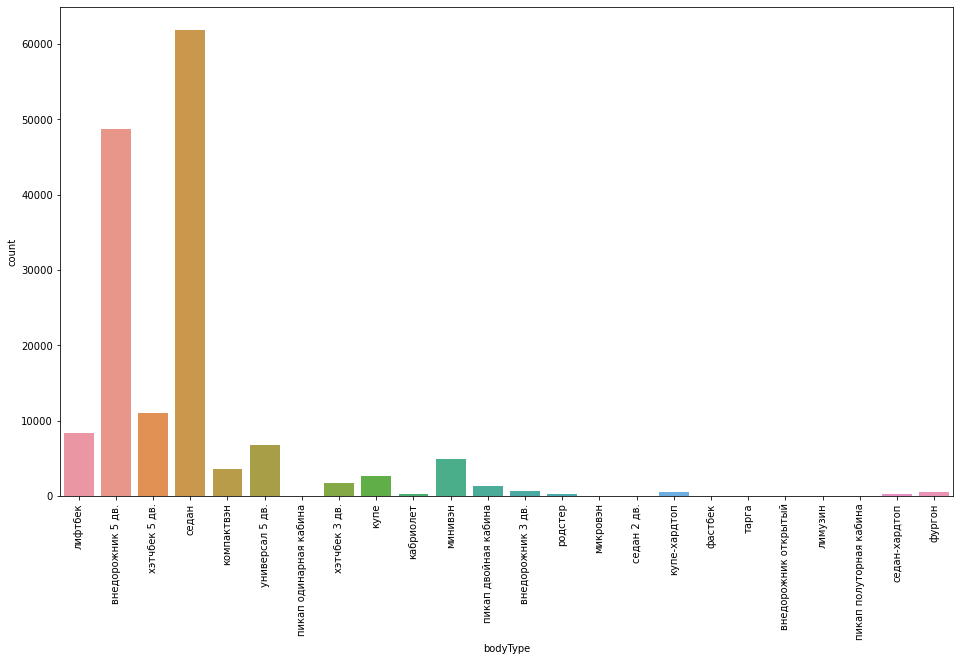

In [60]:
countplot('bodyType', data)

Можно выделить 5-7 наиболее распространенных типов кузовов.

__Идея:__ объединить редкие типы в один или заменить на самые распространенные

__Вывод:__ сделаем dummie-переменные, поэксперементируем с объединением

#### 6.2. brand

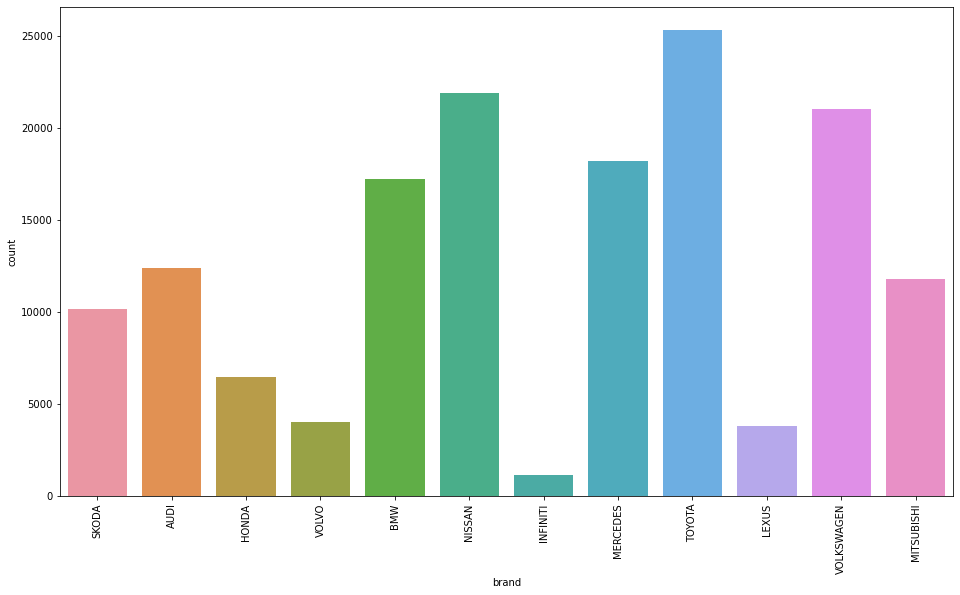

In [61]:
countplot('brand', data)

Можно выделить 3-4 наименее распространенных брендов.

__Идея:__ оценить влияние неравномерного представления моделей в выборке. Возможно, нужно выровнять тренировочную выборку по числу представленных моделей.

__Вывод:__ сделаем dummie-переменные, вопрос к экспертам по выборке

#### 6.3. color

In [62]:
# Заполнение пропусков в 'color' самым популярным значением
col = 'color'
data[col] = data[col].fillna(data[col].mode()[0])

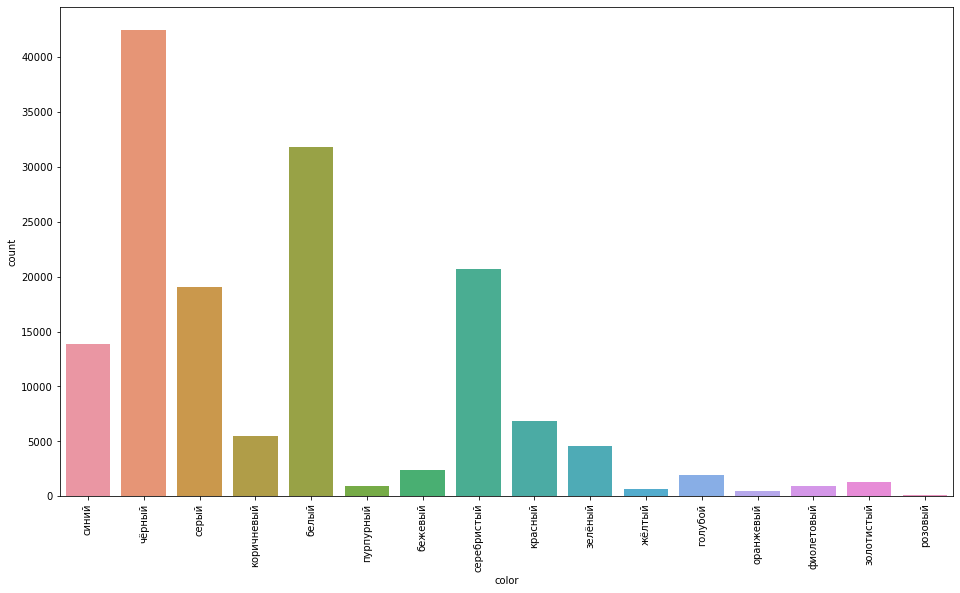

In [63]:
countplot(col, data)

Можно выделить 5 наиболее распространенных цветов.

__Идея:__ на основе 'color' сделать бинарную переменную - является/нет популярным цветом

__Вывод:__ сделаем dummie-переменные, поэксперементируем с новой переменной

#### 6.4. description

In [64]:
# На основе description введем новую переменную исходя из длины комментария продавца
col = 'description'
data[col] = data[col].apply(lambda x: len(str(x)))
data[col] = pd.qcut(data[col], 4, labels=[1, 2, 3, 4])

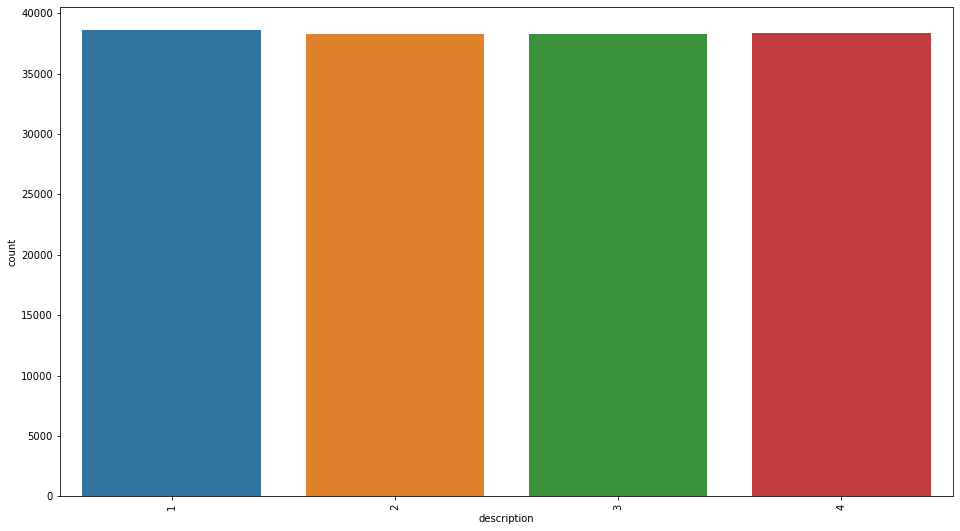

In [65]:
countplot(col, data)

Распределение значений примерно равномерное. 

__Вывод:__ проверим корреляцию этого параметра и важность. Возможно, придется удалить эту переменную.

#### 6.5. engineDisplacement

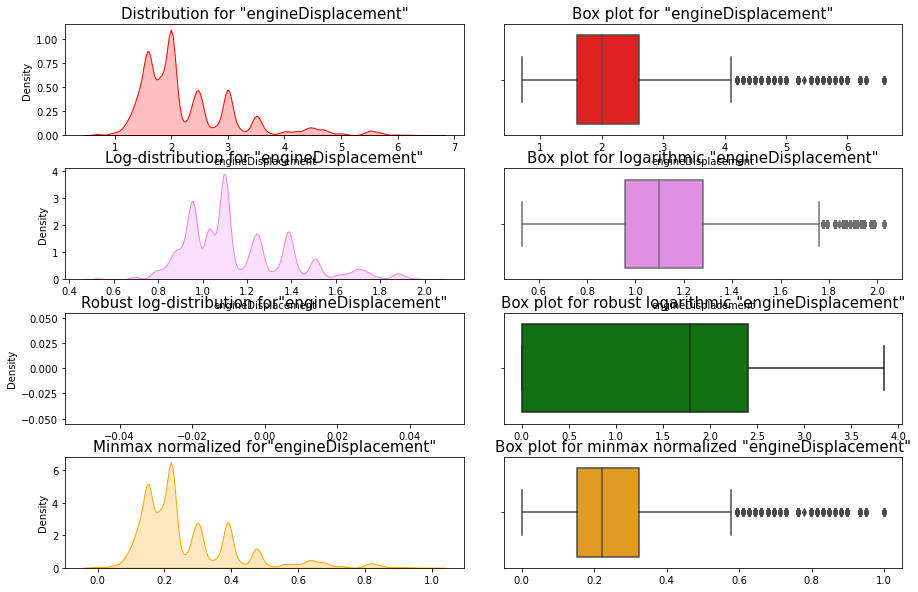

In [66]:
 dist_box(data, 'engineDisplacement')

In [67]:
# Заполнение пропусков в 'engineDisplacement' через мощность двигателя, которая известна и 
# сравнению похожей по другим строкам.
col_1 = 'engineDisplacement'
col_2 = 'enginePower'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    engine_power = data[col_2][idx]
    index_eng_power = data.index[(data[col_2] < engine_power*1.1) & (data[col_2] > engine_power*0.9)].tolist()
    data[col_1][idx] = round(data[col_1][index_eng_power].median(), 1)
#     print(data[col_1][idx])
data[col_1] = data[col_1].fillna(data[col_1].mode()[0])

Наиболее распространены 9 значений.

__Вывод:__ 
- Обратить внимание на корелляцию с мощностью двигателя (предположительно будет высокая). 
- Возможно потребуется дискретизация данного признака (в этом случае использовать stratagy='kmeans').
- Или нормализация min/max.
- Выбросы можно приравнять к 4.0.

#### 6.6. enginePower

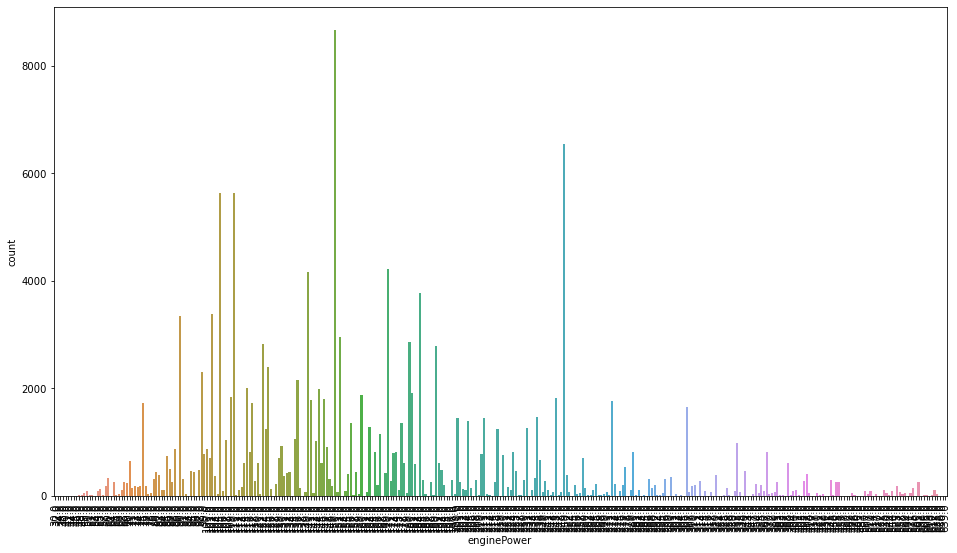

In [68]:
countplot('enginePower', data)

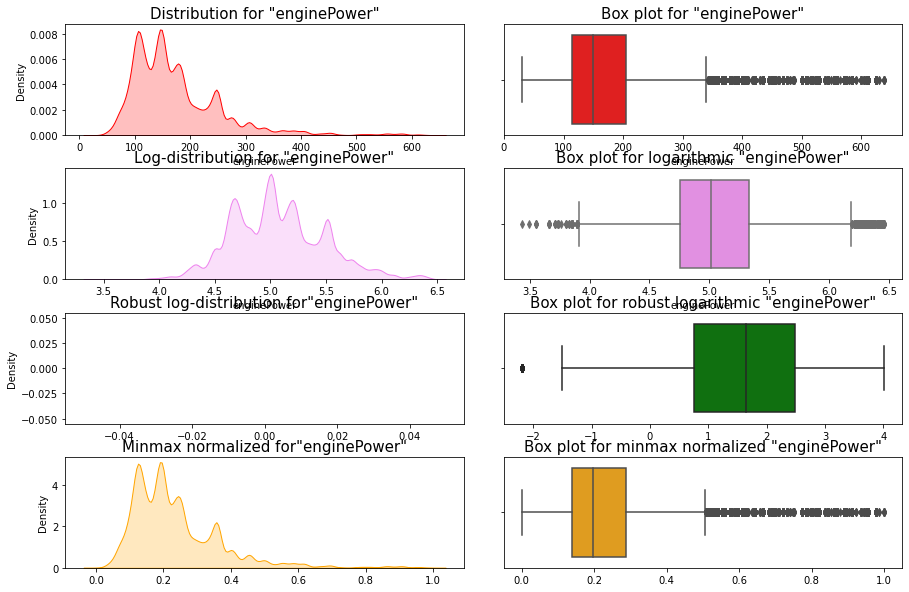

In [69]:
 dist_box(data, 'enginePower')

Распределение данной переменной схоже с engineDisplacement. Выводы те же.

#### 6.7. fuelType

In [70]:
# Заполнение пропусков fuelType на самый распространенный - 'бензин'
col = 'fuelType'
data[col] = data[col].fillna(data[col].mode()[0])
data[col].value_counts()

бензин     126688
дизель      24620
гибрид       1752
электро       464
газ             7
Name: fuelType, dtype: int64

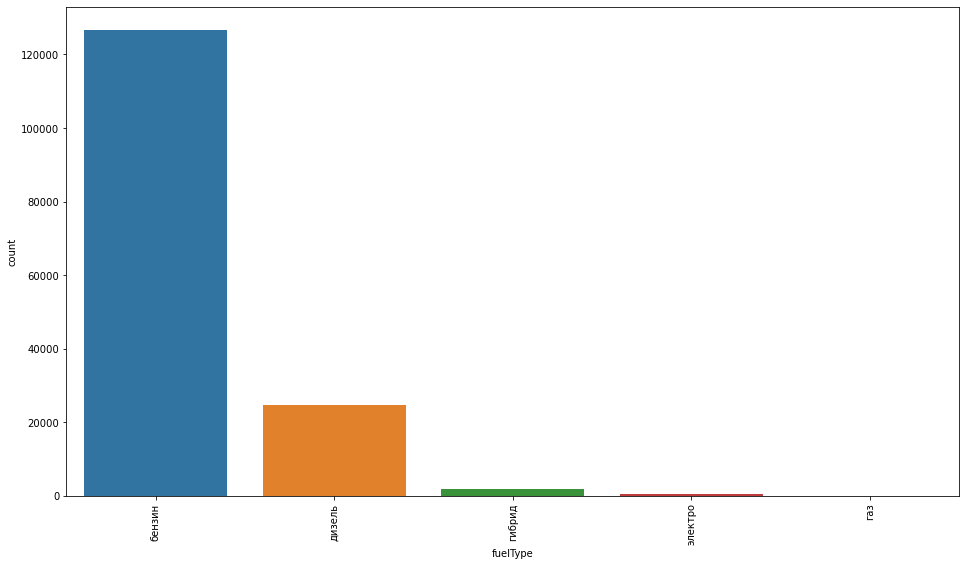

In [71]:
countplot(col, data)

In [72]:
data.loc[data[col]!='газ', col] = 'бензин'

Значений "газ" всего 7, поэтому предлагаю убрать эти строки или заменить на "бензин".

__Вывод:__ Создаем dummie-признаки.

#### 6.8. mileage

In [74]:
# Заполнение пропусков в 'mileage' через год выпуска, который известен и 
# сравнению похожей по другим строкам.
col_1 = 'mileage'
col_2 = 'productionDate'
index_list = data.index[(data[col_1] == 0.0) | (data[col_1].isna())].tolist()
for idx in index_list:
    year = data[col_2][idx]
    if year == 2021:
        data[col_1][idx] = 1000
    else:
        index_year_list = data.index[data[col_2] == year].tolist()
        data[col_1][idx] = round(data[col_1][index_year_list].mean())
    print(data[col_1][idx])

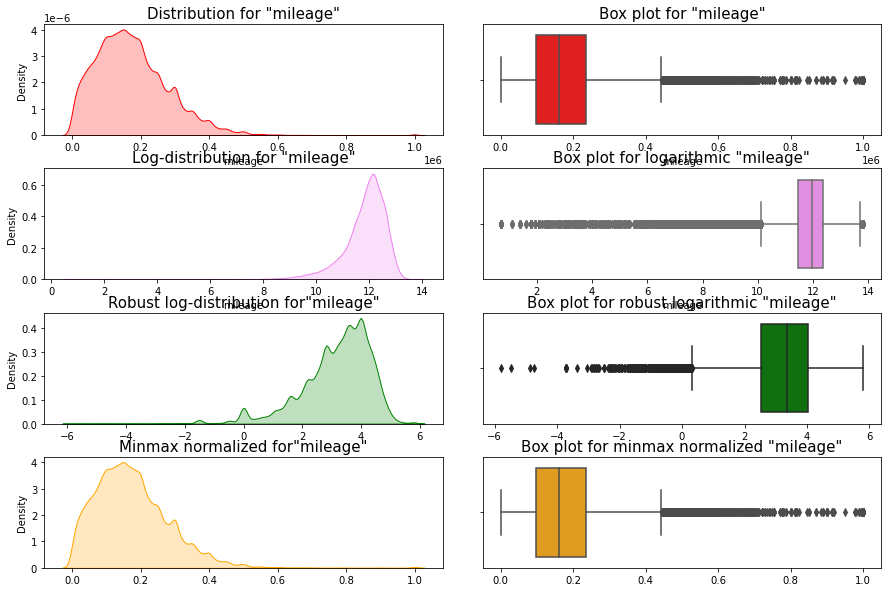

In [75]:
dist_box(data, col_1)

__Вывод:__ 
- Значения > 500 000 приравниваем к 500 000;
- Возможно пригодится дискретизация данного признака;
- Или нормализуем к диапазону (0, 1) методом min/max. Распределение похоже на нормальное. 

#### 6.9. model_name

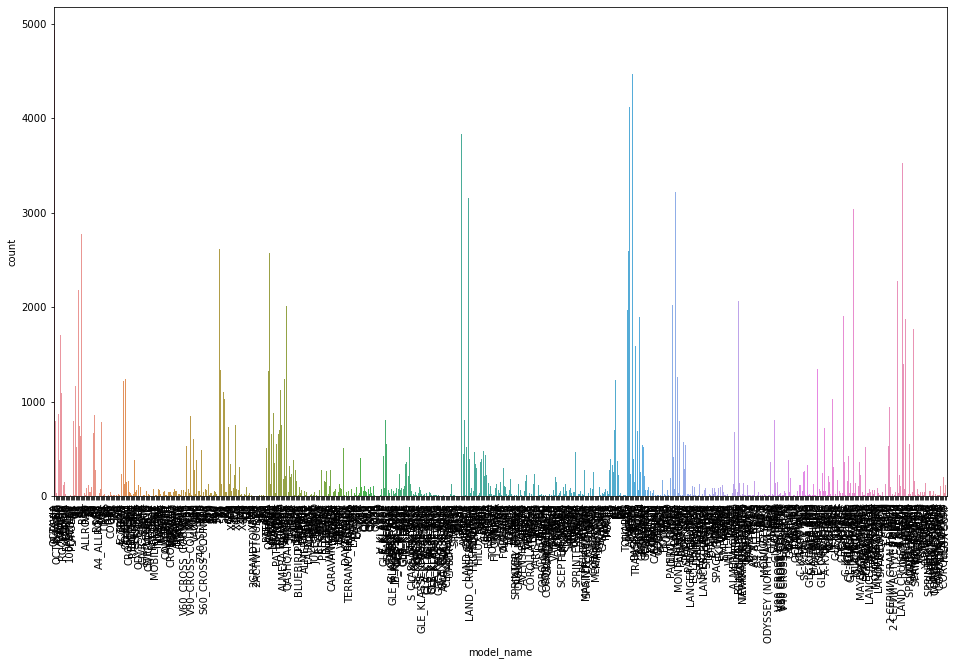

In [76]:
countplot('model_name', data)

__Вывод:__ 
- Количество значений по моделям не равномерное, нужно это учесть при валидации;
- Используем OneHotEncoding.

#### 6.10. parsing_unixtime & productionDate
Данные признаки можно использовать для вычисления периода времени с момента производства автомобиля, т.к. год составления тренировочного и тестового датасетов отличаются.

In [77]:
# #Приведение временных признаков к единому формату
# data['parsing_unixtime'] = pd.to_datetime(data['parsing_unixtime'], unit='s')
# data['parsing_unixtime'] = pd.DatetimeIndex(data['parsing_unixtime']).year
# data['productionDate'] = pd.to_datetime(data['productionDate'], format='%Y')
# data['productionDate'] = pd.DatetimeIndex(data['productionDate']).year

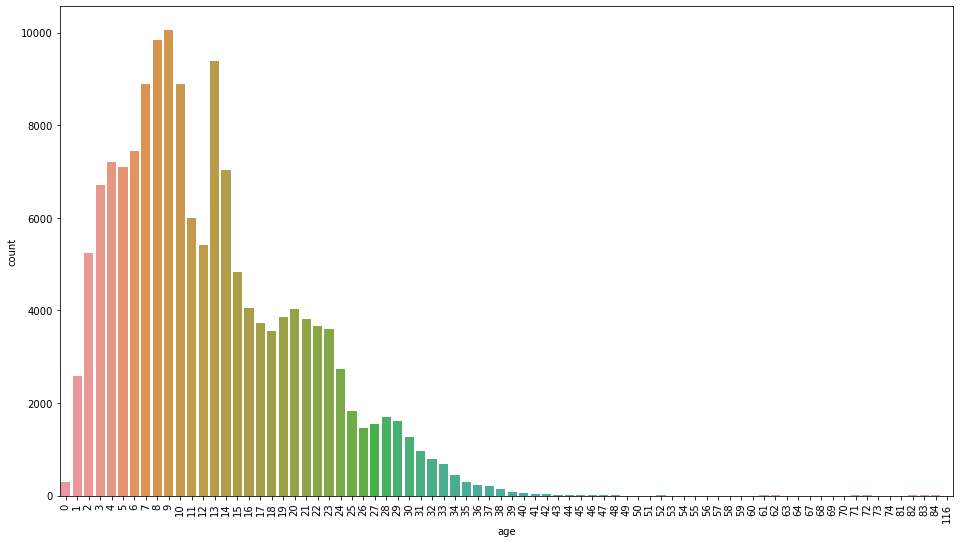

In [78]:
data['age'] = data['parsing_unixtime'] - data['productionDate']
countplot('age', data)

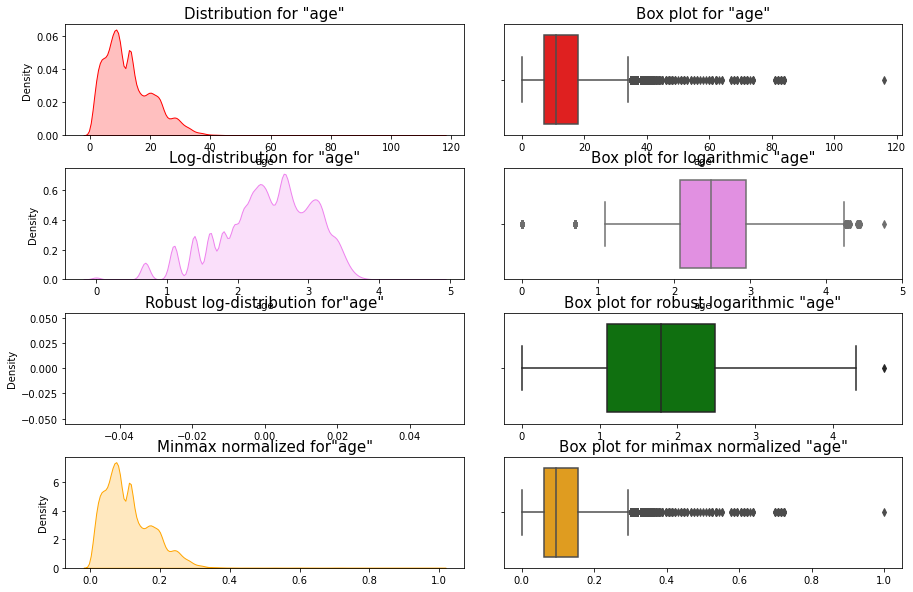

In [79]:
dist_box(data, 'age')

__Вывод:__ 
- Новый признак на их основе: age - кол-во лет с даты производства к году парсинга;
- Удаляем оба старых признака;
- Значения 'age' свыше 35 приравниваем к 35;
- По графику можно отследить кризисные явления в экономике. Снижение кол-ва автомобилей 11-12 лет в продаже соответствует кризису 2008-2010 года;
- Нормализация min/max тоже потребуется.

#### 6.11. vehicleTransmission

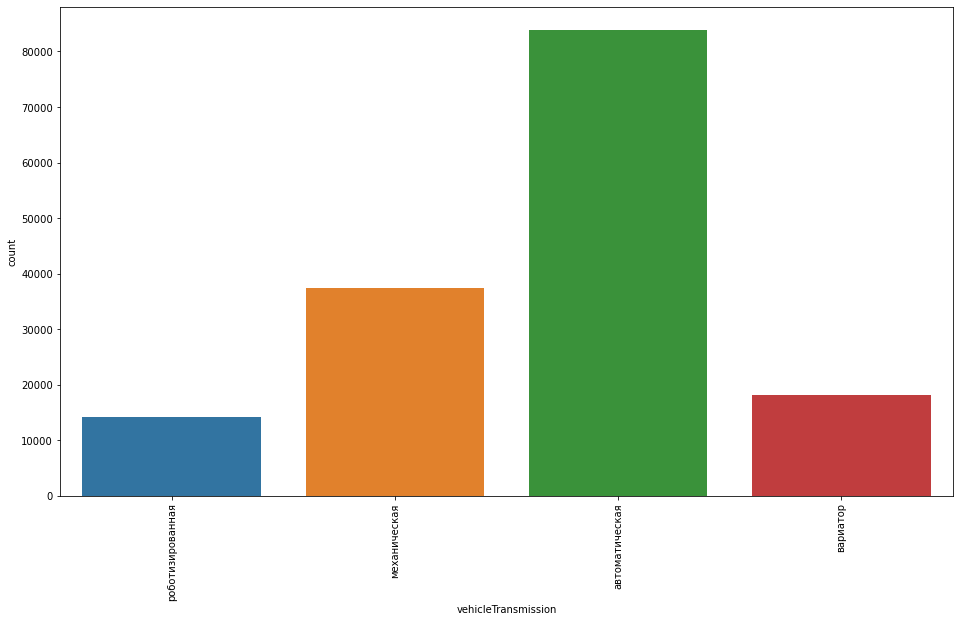

In [80]:
countplot('vehicleTransmission', data)

__Вывод:__ 
Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.12. vendor

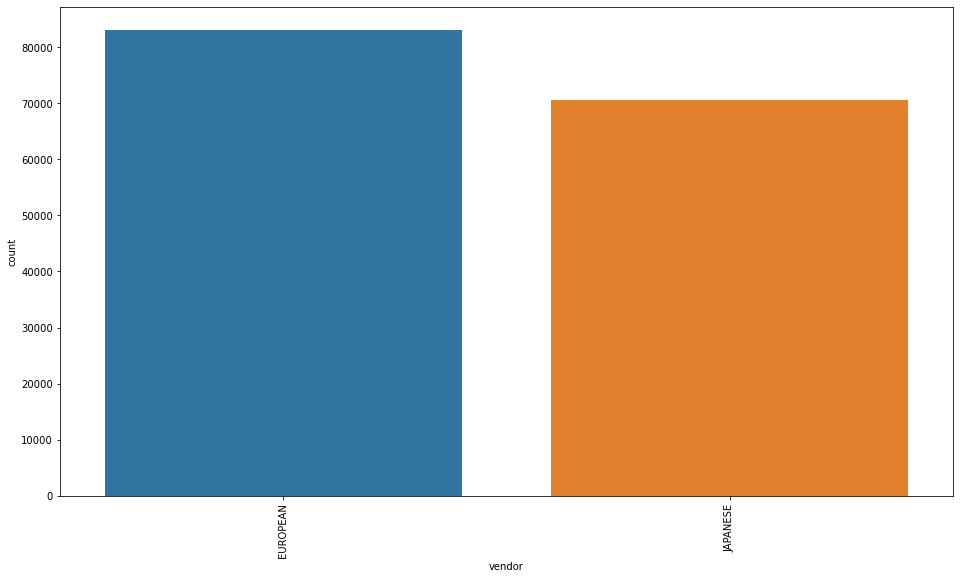

In [81]:
countplot('vendor', data)

__Вывод:__
Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.13. Владельцы
Пропуски меняем на значение 3 (3 и больше).

In [82]:
col = 'Владельцы'
data[col] = data[col].fillna(3.0)

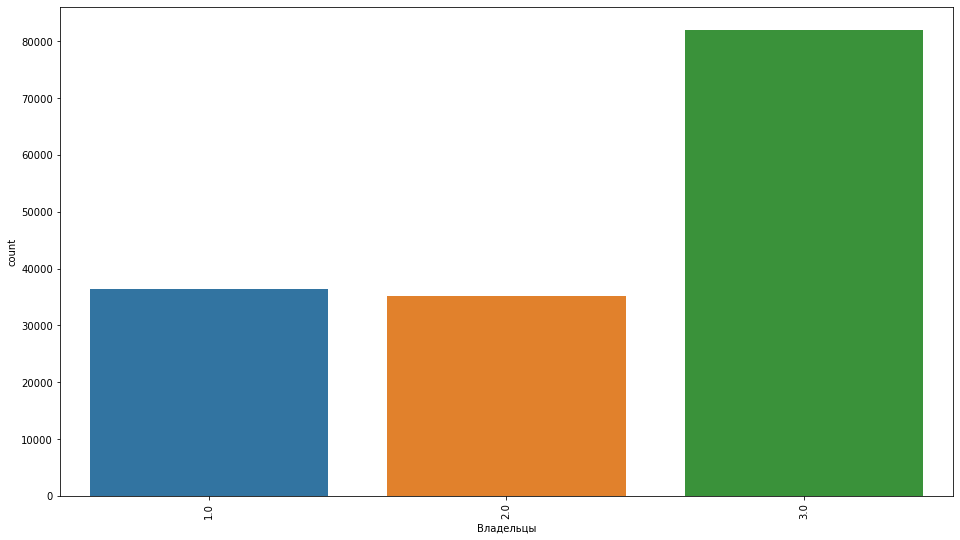

In [83]:
countplot('Владельцы', data)

__Вывод:__
Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.14. Владение
Заполнение пропусков в 'Владение' через год выпуска, который известен и сравнению похожей по другим строкам. Оставшиеся пропуски для редких и старых автомобилей заполним самым распространенным значением.

In [84]:
col_1 = 'Владение'
col_2 = 'productionDate'
index_list = data.index[(data[col_1].isna()) | (data[col_1] == 0.0)].tolist()
for idx in index_list:
    year = data[col_2][idx]
    index_year_list = data.index[data[col_2] == year].tolist()
    data[col_1][idx] = round(data[col_1][index_year_list].median(), 2)
#     print(data[col_1][idx])

data[col_1] = data[col_1].fillna(data[col_1].mode()[0])

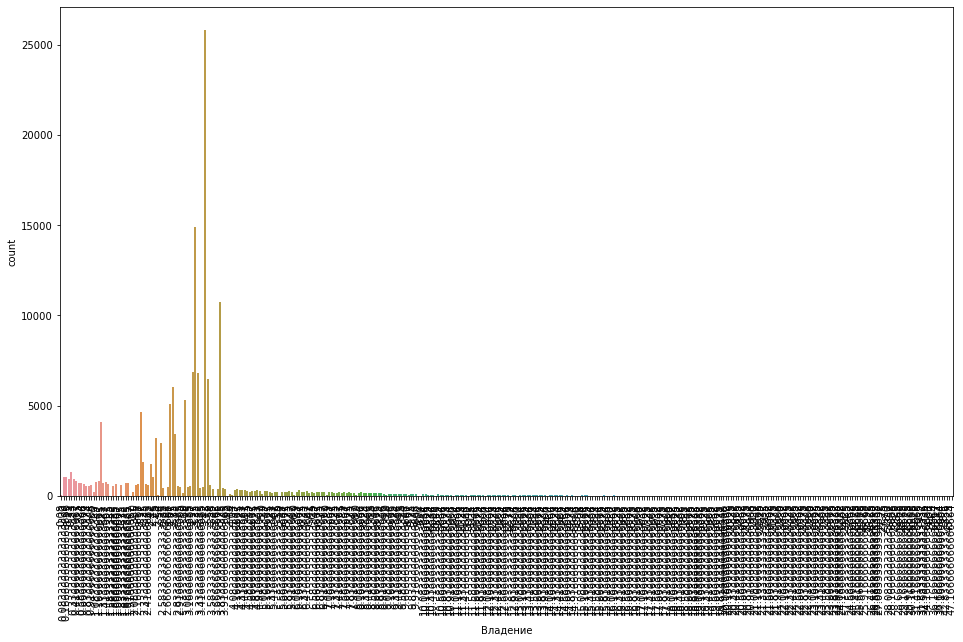

In [85]:
countplot('Владение', data)

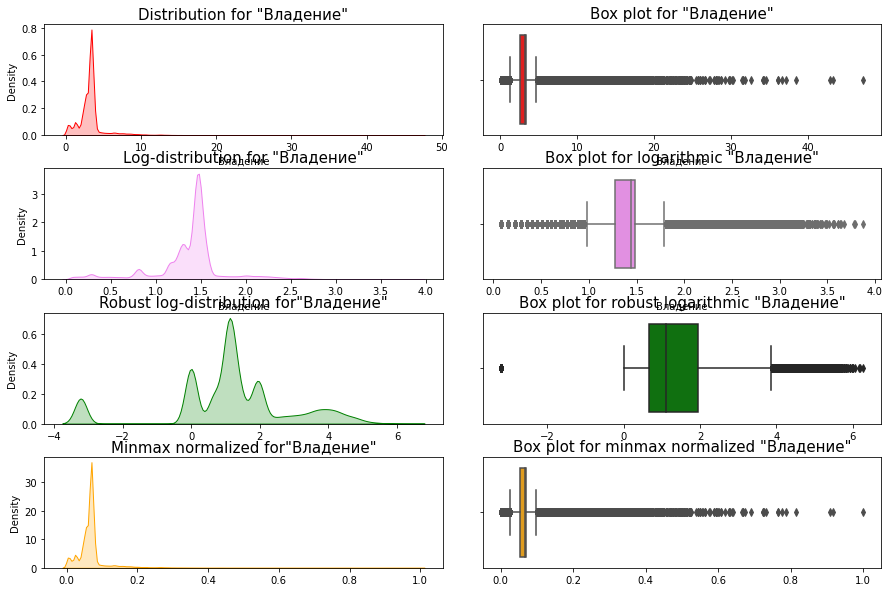

In [86]:
dist_box(data, 'Владение')

__Вывод:__ 
- Распределен нормально, большой хвост справа;
- Удаляем оба старых признака;
- Либо значения свыше 5 приравниваем к 5. Затем нормализуем min/max;
- Либо дискредитизация с OneHotEncoding;

#### 6.15. ПТС
Два варианта: оригинал, дубликат. NaN предлагаю заменить на "дубликат".

In [87]:
col = 'ПТС'
data[col] = data[col].fillna('Дубликат')

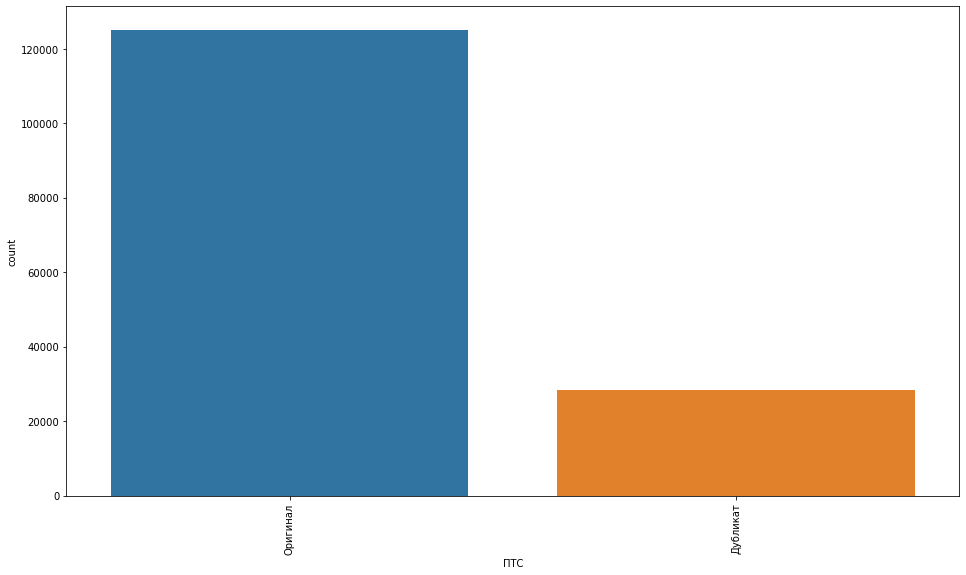

In [88]:
countplot(col, data)

__Вывод:__ Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.16. Привод
Заполнение пропусков в 'Привод' через название модели, который известен и сравнению похожей по другим строкам.

In [89]:
col_1 = 'Привод'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = 'передний'
    else:
        data[col_1][idx] = mode(model_series)
#     print(data[col_1][idx])

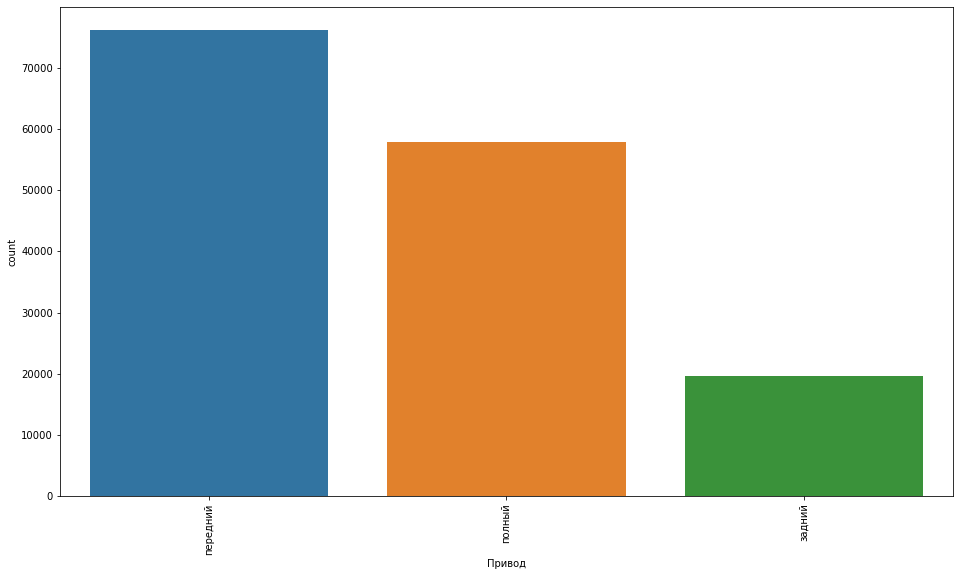

In [90]:
countplot('Привод', data)

__Вывод:__ Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.17. Руль
Заполнение пропусков в 'Руль' через название модели, который известен и сравнению похожей по другим строкам.

In [91]:
col_1 = 'Руль'
col_2 = 'model_name'
index_list = data.index[data[col_1].isna()].tolist()
for idx in index_list:
    model = data[col_2][idx]
    index_model_list = data.index[data[col_2] == model].tolist()
    model_series = data[col_1][index_model_list].loc[~data[col_1][index_model_list].isnull()]
    if len(model_series) == 0:
        data[col_1][idx] = 'Правый'
    else:
        data[col_1][idx] = mode(model_series)
#     print(data[col_1][idx])

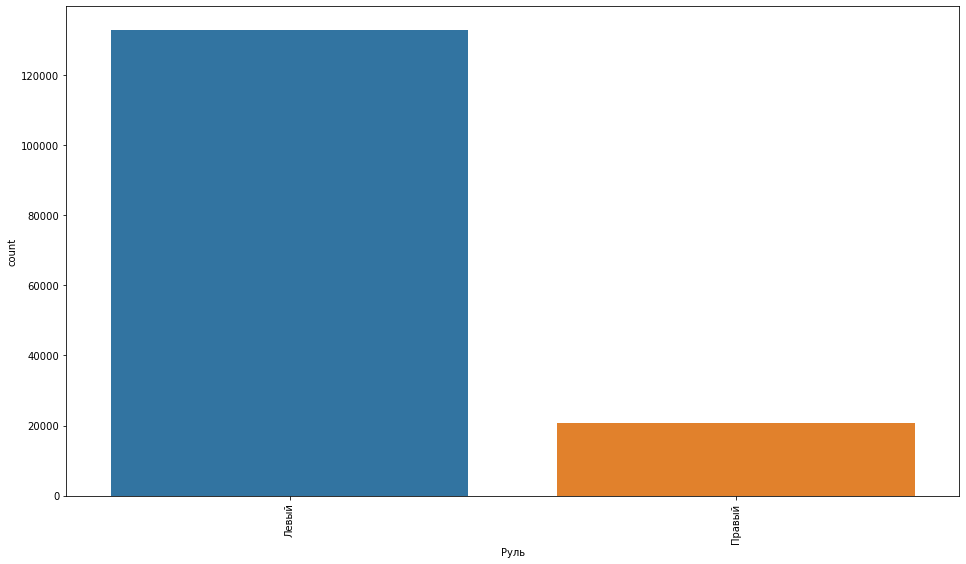

In [92]:
countplot('Руль', data)

__Вывод:__ Все хорошо с данным признаком. Используем OneHotEncoding.

#### 6.18. Price

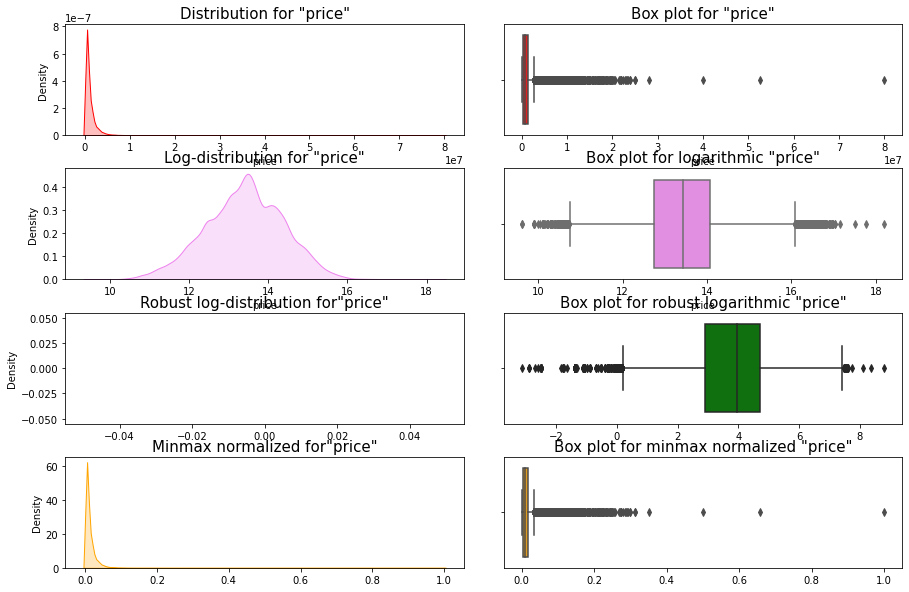

In [93]:
dist_box(data, 'price')

### 7. Feature Engineering

#### 7.1. Приравнивание выбросов к границе 3 квартили

In [94]:
data.loc[data['engineDisplacement'] >= 4, 'engineDisplacement'] = 4
data.loc[data['mileage'] >= 500000, 'mileage'] = 500000
data.loc[data['age'] >= 35, 'age'] = 35
data.loc[data['Владение'] >= 5, 'Владение'] = 5

#### 7.2. Новый признак age.
Разница дат производства и парсинга объявления.

In [95]:
# data['age'] = data['parsing_unixtime'] - data['productionDate']

In [96]:
data = data.drop(['parsing_unixtime', 'productionDate', ], axis=1) # Удалим исходные столбцы

#### 7.3. Типы переменных.

In [97]:
target = 'price'
cat_cols = ['bodyType', 'brand', 'color', 'description', 'fuelType', 'model_name', 'vehicleTransmission', 
             'Владельцы', 'Привод', 'vendor', 'ПТС', 'Руль']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'age', 'Владение']

#### 7.4. Перевод категориальных признаков в dummie.
Закодируем категориальные признаки при помощи get_dummy.

In [98]:
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.shape

(153531, 788)

#### 7.5. Нормализация числовых признаков.
Применяем min/max нормализацию.

In [99]:
scaler = MinMaxScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns = num_cols)

In [100]:
data_num_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153531 entries, 0 to 153530
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   engineDisplacement  153531 non-null  float64
 1   enginePower         153527 non-null  float64
 2   mileage             153531 non-null  float64
 3   age                 153531 non-null  float64
 4   Владение            153531 non-null  float64
dtypes: float64(5)
memory usage: 5.9 MB


#### 7.6. Логарифмирование числовых признаков.
Другой вариант нормализации. Позже сравню эффективность.

In [101]:
data_num_log = pd.DataFrame()
for col in num_cols:
    data_num_log[col] = np.log(data[col])

#### 7.7. Дискретизация числовых признаков.
Третий вариант нормализации. Дискретизация + get_dummies. Позже сравню эффективность.

In [102]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
data_num_disc = pd.DataFrame(disc.fit_transform(data[num_cols]), columns = num_cols)
data_num_disc = pd.get_dummies(data_num_disc, columns = num_cols)
data_num_disc.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 8. Корреляционный анализ

#### 8.1. Корреляция числовых признаков.

In [ ]:
sns.heatmap(data[num_cols + [target]].corr().abs(), vmin=0, vmax=1, annot=True,
            fmt='.2f')

In [ ]:
data_train = data.loc[data.flag=='1']
for col in num_cols:
    p_value = pearsonr(data_train[col], data_train[target])[1]
    if (p_value / len(num_cols)) < 0.05:
        print(f'P-value={p_value} => "{col}" и "{target}" коррелируют')

__Выводы:__
- Все числовые признаки коррелируют с целевой переменной;
- Как и ожидалось, 'enginePower' и 'engineDisplacement' сильно коррелируют. Удалим 'engineDisplacement', т.к. 'enginePower' немного больше коррелирует с целевой переменной;
- 'Владение' имеет самый низкий коэффициент корреляции - кандидат на удаление.

#### 8.2. Корреляция категориальных признаков.

Поскольку у нас есть относительно нормальное распределение цели, давайте проведем тест ANOVA, чтобы определить, какие категории статистически значимы. Существует слишком много уникальных брендов (типов телосложения и т. Д.), чтобы создавать их комбинации (мой ноутбук в основном взрывается), поэтому давайте случайным образом возьмем только десять из них:

In [ ]:
data_train = data.loc[data.flag=='1']
for col in cat_cols:
    if data_train[col].nunique() > 10:
        ten_random_categories = np.random.choice(data_train[col].unique(), 10, replace=False)
        combs = list(combinations(ten_random_categories, 2))
    else:
        combs = list(combinations(data_train[col].unique(), 2))
    for pair in combs:
        p_value = f_oneway(data_train[data_train[col] == pair[0]][target],
                           data_train[data_train[col] == pair[1]][target]).pvalue
        if p_value < 0.01:
            print(f'"{col}" признак статистически значим')
            break

__Выводы:__
- Все категориальные признаки могут объяснить вариативность целевой переменной;

In [104]:
data.to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/data_all.xlsx')
data_num_scaled.to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/data_scaled.xlsx')
data_num_log.to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/data_log.xlsx')
# data_num_disc.to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/data_disc.xlsx')
# data_cat.to_excel('C:/Users/shers/Desktop/SF/Проекты/Выбираем авто выгодно/data_cat.xlsx')

### 9. Моделирование

In [103]:
data_x = data[data['flag'] == '0']
data_x.shape

(34686, 19)